<a href="https://colab.research.google.com/github/ziatdinovmax/atomai/blob/master/examples/notebooks/atomai_atomnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short tutorial on how to use *atomnet* module

Prepared by Maxim Ziatdinov

E-mail: maxim.ziatdinov@ai4microscopy.com

## Install AtomAI

Install AtomAI:

In [1]:
!pip install atomai

  Cloning https://github.com/ziatdinovmax/atomai to /tmp/pip-req-build-ehdoyt8v
  Running command git clone -q https://github.com/ziatdinovmax/atomai /tmp/pip-req-build-ehdoyt8v
  Created wheel for atomai: filename=atomai-0.4.0-cp36-none-any.whl size=57699 sha256=9cf1c73a77fb1568b6ec7f5e513385e057934d08f83b858698eb6d5af7a19444
  Stored in directory: /tmp/pip-ephem-wheel-cache-u2wgffsq/wheels/49/47/01/932ce6186e3f5af7f35fd44f2adffc226972afec7027d43ff6
Successfully built atomai


Import modules:

In [2]:
import atomai as aoi
import numpy as np

## Single-class model

We start by (down)loading the training data, which is based on a single labeled experimental STEM image of Sm-doped BFO containing ~20,000 atomic unit cells (see *arXiv:2002.04245* and the associated notebook). The original image was ~3000 px x 3000 px. We randomly cropped about 2000 image-label pairs of 256 x 256 resolution and then applied different image "distortions" (noise, blurring, zoom, etc.) to each cropped image, treating all atoms as one class. Because the training data are just numpy arrays you can easily vizualize it with standard matplotlib functions. You can pass the training/test images and labels as 4 separate numpy arrays with the dimensions ```(n_images, n_channels=1, image_height, image_width)``` for training images, ```(n_images, n_channels=1, image_height, image_width)``` for labels with only one class of atoms (or all atoms treated as one class) and ```(n_images, image_height, image_width)``` for labels with multiple classes or as 4 separate python lists (or dictionaries) where each element in a list (or value in a dictionary) is a small numpy array (typically containing from 8 to 32 images). Notice that even if yoy forgot to add a pseudo-channel of 1 to your data, AtomAI will do it for you (and display a warning). After training a model we will apply it to an experimental image from a different experiment/system (La-doped BFO) to see if it can find atoms in that previously unseen data. 

In [3]:
download_link = 'https://drive.google.com/uc?id=1-0fXGXGY8jW11q2GdPZ2hmOhQ7-WNlnK'
!gdown -q $download_link -O 'training_data.npy'
dataset_1 = np.load('training_data.npy')
images_all_1 = dataset_1['X_train']
labels_all_1 = dataset_1['y_train']
images_test_all_1 = dataset_1['X_test']
labels_test_all_1 = dataset_1['y_test']
print(images_all_1.shape, labels_all_1.shape)

(1600, 1, 256, 256) (1600, 1, 256, 256)


After loading training data we can go straight to model training. This is because we believe that we already found an optimal neural network architecture for atom/defect finding ( see e.g. *Applied Physics Letters 115, 052902 (2019)*, *Advanced Functional Materials 29, 1904480 (2019)* ) and because we also found that the small improvements in the accuracy on the standard datasets like ImageNet due to the tweaks to the network's architecture are somewhat meaningless for the noisy experimental data as they usually are within the "error bar".

The model training is esentially one line of code. The final model weights will be saved automatically (by default they will be saved to the root directory, but you can change that).

Epoch 1 ... Training loss: 0.7418 ... Test loss: 0.7449 ... GPU memory usage: 4477/16280
Epoch 100 ... Training loss: 0.3637 ... Test loss: 0.3221 ... GPU memory usage: 4479/16280
Epoch 200 ... Training loss: 0.2464 ... Test loss: 0.2572 ... GPU memory usage: 4479/16280
Epoch 300 ... Training loss: 0.234 ... Test loss: 0.2329 ... GPU memory usage: 4479/16280
Epoch 400 ... Training loss: 0.21 ... Test loss: 0.2311 ... GPU memory usage: 4479/16280
Epoch 500 ... Training loss: 0.2404 ... Test loss: 0.2199 ... GPU memory usage: 4479/16280
Epoch 600 ... Training loss: 0.203 ... Test loss: 0.2062 ... GPU memory usage: 4479/16280
Epoch 700 ... Training loss: 0.1845 ... Test loss: 0.2167 ... GPU memory usage: 4479/16280
Epoch 800 ... Training loss: 0.1991 ... Test loss: 0.2361 ... GPU memory usage: 4479/16280
Epoch 900 ... Training loss: 0.1987 ... Test loss: 0.2457 ... GPU memory usage: 4479/16280
Epoch 1000 ... Training loss: 0.1909 ... Test loss: 0.198 ... GPU memory usage: 4479/16280
Model

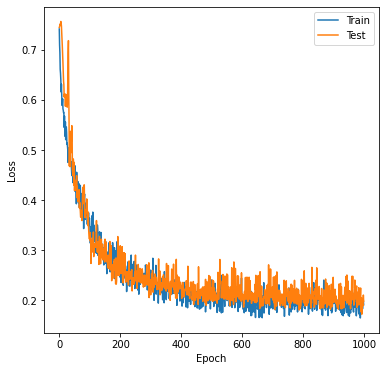

In [4]:
trained_model_1 = aoi.atomnet.trainer(
    images_all_1, labels_all_1, 
    images_test_all_1, labels_test_all_1,
    training_cycles=1000).run()

Now let's make a prediction on the image from a different experiment ( the data is from our paper in *Applied Physics Letters 115, 052902 (2019)* ). Notice that ```atomnet.predictor``` also returns the actual image that was fed into a neural network, which sometimes may not be identical to the image that was loaded (e.g. if an extra padding is needed or if we choose to resize it).

In [5]:
# Load "validation" data
expdata = dataset_1['validation_img']
# Get NN output with atomic coordinates
predictive = aoi.atomnet.predictor(trained_model_1, refine=False, use_gpu=True)
nn_input, (nn_output, coordinates_1) = predictive.run(expdata)

Batch 1/1
1 image was decoded in approximately 0.1576 seconds


Plot results:

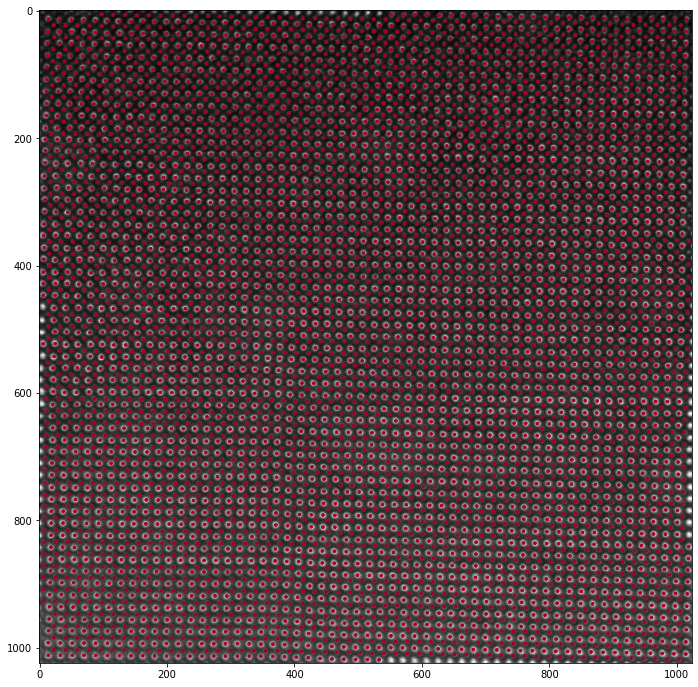

In [6]:
aoi.utils.plot_coord(expdata, coordinates_1[0], fsize=12)

Looks like our model performed quite well on the previously unseen data! There is no ground truth for the experimental data, so evaluating accuracy is somewhat tricky, but we can compare our results with the results of other methods (something that will be added in the near future). Notice that you can also perform a refinement of your model predictions with Gaussian peak fitting using the predicted cooordinates as initial guess by adding ```refine=True``` to ```atomnet.predictor```. In addition you can also set a size of a region around predicted positions in which the peak fitting is performed using ```d``` parameter (by default, ```d``` is equal to 1/4 of average nearest neighbor atomic distance in the lattice).

Notice that it is always a good idea to train your model on a diverse training set (e.g. many labeled expermental images, or simulated data for variety of atomic structures/positions). Here we used a training set made from a single image just to show a *quick* example of how atomnet module works. Such a model will not generalize very well.

## Multi-class model

We now repeat the same routines but for the training data where different atomic elements correspond to different classes (the experimental image used for generation of this training data is the same as for the single-class case). The structure of the training data is similar to what we had in the single-class case (notice, however, that the labels are now a 3D array, without a channel dimension) and also can be easily vizualized with matplotlib.

(Down)load data:

In [7]:
download_link = 'https://drive.google.com/uc?id=1-4-IQ71m--OelQb1891GnbG1Ako1-DKh'
!gdown -q $download_link -O 'training_data-m.npy'
dataset_2 = np.load('training_data-m.npy')
images_all_2 = dataset_2['X_train']
labels_all_2 = dataset_2['y_train']
images_test_all_2 = dataset_2['X_test']
labels_test_all_2 = dataset_2['y_test']
print(images_all_2.shape, labels_all_2.shape)

(1656, 1, 256, 256) (1656, 256, 256)


Train a model:

Epoch 1 ... Training loss: 1.2691 ... Test loss: 1.2142 ... GPU memory usage: 5091/16280
Epoch 100 ... Training loss: 0.441 ... Test loss: 0.3785 ... GPU memory usage: 5091/16280
Epoch 200 ... Training loss: 0.2737 ... Test loss: 0.2756 ... GPU memory usage: 5091/16280
Epoch 300 ... Training loss: 0.2317 ... Test loss: 0.2228 ... GPU memory usage: 5091/16280
Epoch 400 ... Training loss: 0.2019 ... Test loss: 0.2372 ... GPU memory usage: 5091/16280
Epoch 500 ... Training loss: 0.1907 ... Test loss: 0.2144 ... GPU memory usage: 5091/16280
Epoch 600 ... Training loss: 0.1894 ... Test loss: 0.2231 ... GPU memory usage: 5091/16280
Epoch 700 ... Training loss: 0.1801 ... Test loss: 0.2138 ... GPU memory usage: 5091/16280
Epoch 800 ... Training loss: 0.1793 ... Test loss: 0.2008 ... GPU memory usage: 5091/16280
Epoch 900 ... Training loss: 0.1914 ... Test loss: 0.182 ... GPU memory usage: 5091/16280
Epoch 1000 ... Training loss: 0.1812 ... Test loss: 0.1824 ... GPU memory usage: 5091/16280
Mo

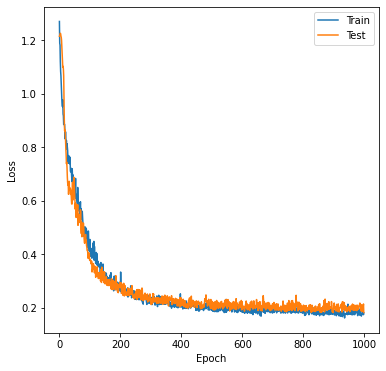

In [8]:
trained_model_2 = aoi.atomnet.trainer(
    images_all_2, labels_all_2, 
    images_test_all_2, labels_test_all_2,
    training_cycles=1000).run()

Get a prediction on the same image as in the single-class case:

In [9]:
# Get NN output with atomic cooridnates and classes
predictive = aoi.atomnet.predictor(trained_model_2, refine=False, use_gpu=True)
nn_input, (nn_output, coordinates_2) = predictive.run(expdata)

Batch 1/1
1 image was decoded in approximately 0.168 seconds


Plot results:

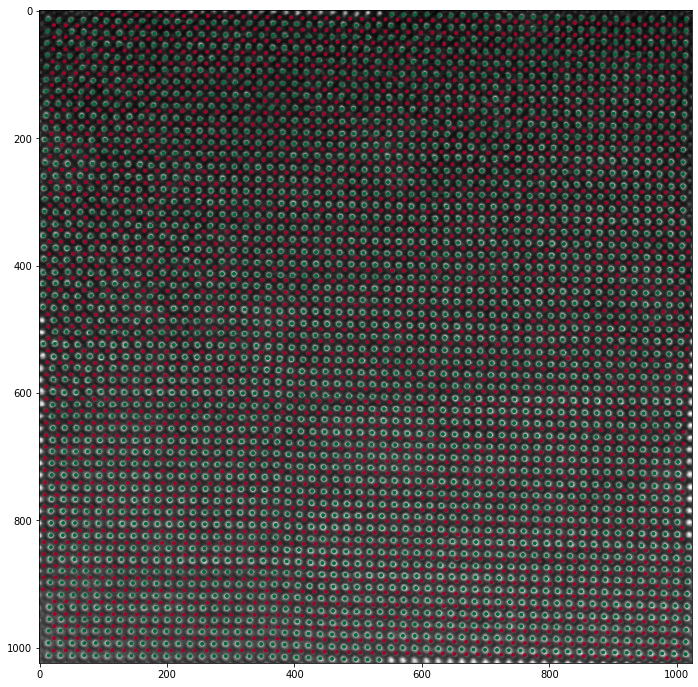

In [10]:
aoi.utils.plot_coord(expdata, coordinates_2[0], fsize=12)

Our model can now distinguish between two different sublattices. This was achieved by changing the training set, while the deep learning model architecture remained the same. Notice that it seems like our some model misclassified some atoms in certain areas. It is worth noting that the sample is doped, which wasn't take into account in our training set. Therefore, the "misclassification" might be due to the doping.